一、数据准备
=============

第一步，加载所有可能用到的模块

In [4]:
"""
客户细分
"""
#1. 数据准备
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

加载数据，进一步提供了一些关于dataframe数据内容的基本信息:各种变量的类型、空值的数量以及它们相对于条目总数的百分比

In [3]:
#__________________
# 读入数据
# df_initial = pd.read_excel("F:\\important_book\\数据分析\\电商数据挖掘\\Online Retail.xlsx",
#                          dtype={'InvoiceID': str})
# df_initial = pd.read_excel("F:\\important_book\\数据分析\\电商数据挖掘\\Online Retail.xlsx",encoding="ISO-8859-1",
#                          dtype={'CustomerID': str,'InvoiceNo': str})
df_initial = pd.read_excel("F:\\Ecommerce\\data\\Online_Retail.xlsx",encoding="ISO-8859-1",
                          dtype={'InvoiceNo': str})

In [4]:
#数据框大小
print('数据框大小:', df_initial.shape)
#______将订单时间列转化为datetime 格式
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values给一些列的类型和每列空的值的个数信息
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
# tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
# tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
#                          rename(index={0:'null values (%)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isna().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isna().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
#展示数据框列的一些属性信息
display(tab_info)
#__________________
# show first lines展示前面五行
display(df_initial[:5])

数据框大小: (541909, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Successful
column type,object,object,object,int64,datetime64[ns],float64,float64,object,int64
null values (nb),0,0,1454,0,0,0,135080,0,0
null values (%),0,0,0.268311,0,0,0,24.9267,0,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Successful
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1


二、数据预处理
===========
在查看dataframe数据中的空值数量时，25%的条目没有分配给特定的客户，由于对于每一个消费者ID为空的订单下所有的消费者ID均为空、所以对与用户ID的填补就很困难，于是我把它们从dataframe数据中删除。

In [5]:
##按行删除CustomerID列的空值
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('数据框大小:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

数据框大小: (406829, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Successful
column type,object,object,object,int64,datetime64[ns],float64,float64,object,int64
null values (nb),0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0


因此，通过删除这些条目，我们最终得到一个100%填充所有变量的数据框。最后，检查重复条目并删除它们

In [6]:
#删除重复项
print('重复的条目行数: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

重复的条目行数: 5225


三、经营状况分析（部分）
===================
这个dataframe数据包含8个变量，对应于:
InvoiceNo-发票号码（订单编号）。标称的，唯一分配给每个订单的6位整数。如果此代码以字母“c”开头，则表示取消。
StockCode--产品代码。标称的，一个5位数的整数，唯一地分配给每个不同的产品。
Description--产品名称。
Quantity--每次交易的每个产品的数量。 
InvoiceDate--订单发生的交易日期和时间。数字，每个订单生成的日期和时间。
UnitPrice--单位价格（英镑）。 
CustomerID--客户编号。
Country--客户所属的国家。


2.1国家
----------
在这里，我快速地看一下订单来自哪些国家，并在地图上显示结果

In [251]:
"""
2. 探索变量的内容
"""
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Nb. de pays dans le dataframe: {}'.format(len(countries)))

Nb. de pays dans le dataframe: 37


In [252]:
import plotly.graph_objs as go
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

我们看到，数据主要由来自英国的订单主导。

2.2客户与产品
-----------
dataframe数据包含400,000个条目。这些条目中有多少用户和产品?

In [253]:
#2.2客户与产品
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


可以看出，数据涉及4372名用户，他们购买了3684种不同的产品。执行的订单总数约为22,000。


现在将确定每笔交易购买的产品数量:

In [254]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


清单的第一行显示了几件值得注意的事情:

InvoiceNo-发票号码（订单编号）变量前缀C的条目的存在:这表示已经取消的订单

用户的存在只能有一次,而且只购买一个产品

经常购买大量商品的用户存在

2.2.1取消订单

首先，我计算被取消订单对应的交易数量

In [256]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


我们注意到取消的数量非常大(约为订单总数的16%)。现在，看一下dataframe数据的第一行:

In [257]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Successful,UnitPrice1,UnitPrice2,UnitPrice3,UnitPrice4,tollPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,1,1.04,1.04,1.04,1.04,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,0,1.04,1.04,1.04,1.04,-77183.6
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland,1,4.25,4.25,4.25,4.25,17.0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland,1,0.55,0.55,0.55,0.55,13.2
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland,1,1.25,1.25,1.25,1.25,15.0


在这几行代码中，我们看到当订单被取消时，数据中还有另一个订单，除了Quantity和InvoiceDate-订单发生的交易日期和时间变量外，其他订单基本相同。我决定检查一下是否对所有条目都是正确的。为此，我决定查找表示负数的条目，并检查是否有一个系统的订单表示相同的数量(但为正数)，描述相同(CustomerID、description和单价)

In [258]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


我们看到最初的假设没有得到满足，因为存在一个“折扣”条目。我再次检查假设，但这次放弃了“折扣”条目

In [259]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


再一次，我们发现最初的假设没有得到验证。因此，取消订单并不一定对应于预先发出的订单。
此时，我决定在dataframe数据中创建一个新变量，该变量指示是否取消了命令的一部分。对于没有对应项的取消，其中一些可能是由于购买订单是在2010年12月之前执行的(数据库的入口点)。下面，我对取消订单进行了统计，并检查是否存在对应的订单。


In [260]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

在上面的函数中，我检查了两种情况:
1.	取消订单没有对应的存在，
2.	至少有一个对应的数量完全相同

对应的取消订单的索引分别保存在doubtfull_entry和entry_to_remove列表中，其大小分别为:

In [17]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


在这些条目中，doubtfull_entry列表中列出的行对应于表示取消但事先没有命令的条目。实际上，我决定删除所有这些条目，它们分别占数据aframe条目的1.4%和0.2%。

现在我检查与取消相对应的条目的数量，这些条目没有被之前的过滤器删除


In [17]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422.0,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754.0,United Kingdom,0


例如，你就会注意到如果你看到消费者购买了上述其中一项，并且与取消该项目的产品相对应

In [261]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Successful,UnitPrice1,UnitPrice2,UnitPrice3,UnitPrice4,tollPrice,QuantityCanceled


我们看到被取消的数量大于之前购买的数量之和。

2.2.2 StockCode-产品代码

在上面，可以看到StockCode-产品代码变量的一些值表示一个特定的订单(即D代表折扣)。我通过查找一组只包含字母的代码来检查这个变量的内容


In [262]:
#2.2.2 StockCode
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)==True]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [263]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


2.2.3篮子的价格

创建了一个新的变量，表示每次购买的总价格:


In [264]:
#2.2.3篮子的价格
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Successful,UnitPrice1,UnitPrice2,UnitPrice3,UnitPrice4,tollPrice,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,1,1.04,1.04,1.04,1.04,77183.6,74215,0.0
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,0,1.04,1.04,1.04,1.04,-77183.6,0,-77183.6
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland,1,4.25,4.25,4.25,4.25,17.0,0,17.0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland,1,0.55,0.55,0.55,0.55,13.2,0,13.2
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland,1,1.25,1.25,1.25,1.25,15.0,0,15.0


数据的每一项都表示对某一种产品的购买。因此，订单被分成几行。收集在一个订单期间的所有购买之和

In [265]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
2,12347.0,537626,711.79,2010-12-07 14:57:00.000001024
3,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
4,12347.0,549222,636.25,2011-04-07 10:42:59.999999232
5,12347.0,556201,382.52,2011-06-09 13:01:00.000000256
6,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
7,12347.0,573511,1294.32,2011-10-31 12:25:00.000001280


为了对这个数据集中执行的订单类型有一个全局视图，我决定如何根据每一个订单的总购买来划分购买

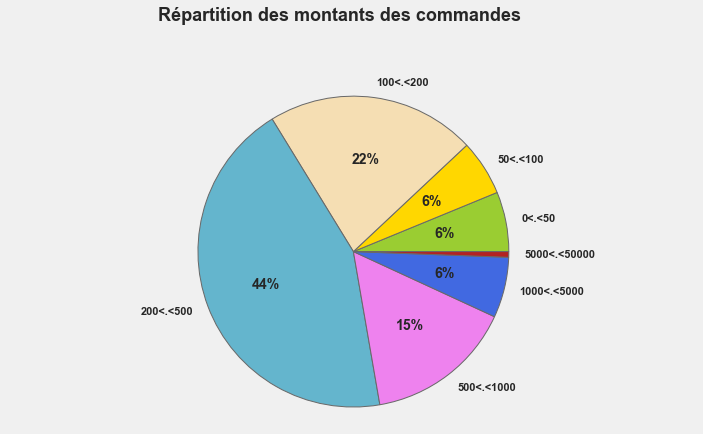

In [266]:
#____________________
# Décompte des achats
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Représentation du nombre d'achats / montant        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Répartition des montants des commandes", ha='center', fontsize = 18);

四、产品聚类
==============================
在dataframe数据中，产品是通过StockCode-产品代码变量惟一标识的。产品的简短描述在description变量中给出。在本节中，我打算使用后一个变量的内容，以便将产品分组到不同的类别中。

4.1数据准备
------------------
作为第一步，我从Description变量中提取将被证明有用的信息。为此，我使用以下函数:


In [35]:
#3.对产品类别的洞察


In [267]:
##提取产品的最低价，最高价，均值，价格方差，销量方差

# print (df_initial.head())
# df_initial.info() 
import datetime as dt
NOW = dt.datetime(2010,12,10)
df_initial['UnitPrice1']=df_initial['UnitPrice']
df_initial['UnitPrice2']=df_initial['UnitPrice']
df_initial['UnitPrice3']=df_initial['UnitPrice']
df_initial['UnitPrice4']=df_initial['UnitPrice']
df_initial['tollPrice']=df_initial['UnitPrice']*df_initial['Quantity']
# print (df_initial.head())


# df_productclass=df_initial.groupby('StockCode').agg({ 'Quantity':'sum', 'UnitPrice':'min', 'UnitPrice1':'max','UnitPrice2':'mean',\
#                                                      'UnitPrice3':'std', 'InvoiceDate':lambda x:(x.max()-NOW).days})


df_productclass=df_initial.groupby('StockCode').agg({ 'Quantity':'sum', 'UnitPrice':'min', 'UnitPrice1':'max','UnitPrice2':'mean',\
                                                     'UnitPrice3':'std'})
df1=df_initial.groupby(['StockCode','Country']).agg({ 'tollPrice':'sum'}).copy()
df2=df1.unstack().fillna(0,inplace=True)

In [268]:
tab_info=pd.DataFrame(df_productclass.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_productclass.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_productclass.isnull().sum()/df_productclass.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,Quantity,UnitPrice,UnitPrice1,UnitPrice2,UnitPrice3
column type,int64,float64,float64,float64,float64
null values (nb),0,0,0,0,161
null values (%),0,0,0,0,4.37025


In [269]:
df_p=pd.DataFrame(df_productclass.values,index=df_productclass.index,columns=df_productclass.columns)
df_p.fillna(0,inplace=True)
df_p.head()


,Quantity,UnitPrice,UnitPrice1,UnitPrice2,UnitPrice3
StockCode,,,,,
10002,823.0,0.85,0.85,0.850000,0.000000
10080,291.0,0.39,0.85,0.411905,0.100380
10120,192.0,0.21,0.21,0.210000,0.000000
10125,1225.0,0.42,0.85,0.781746,0.158395
10133,2363.0,0.42,0.85,0.528374,0.187461


In [270]:
tab_info=pd.DataFrame(df_p.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_p.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_p.isnull().sum()/df_p.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,Quantity,UnitPrice,UnitPrice1,UnitPrice2,UnitPrice3
column type,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0
null values (%),0,0,0,0,0


4.2聚类分析
-------------------

In [271]:
#产品聚类：
from sklearn import preprocessing
scaled_matrix=df_p.copy()
scaled_matrix = preprocessing.scale(scaled_matrix)#数据标准化

for i in range(3,15):
    n_clusters = i
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    def euc_dist(X, Y):
        #return pairwise_distances(X, Y, metric = 'cosine', n_jobs = 10)
        return np.arccos(cosine_similarity(X, Y))/np.pi
    kmeans.euclidean_distances = euc_dist
    
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('{}score de silhouette: {:<.3f}'.format(i,silhouette_avg))

    

3score de silhouette: 0.939
4score de silhouette: 0.899
5score de silhouette: 0.759
6score de silhouette: 0.611
7score de silhouette: 0.624
8score de silhouette: 0.610
9score de silhouette: 0.560
10score de silhouette: 0.558
11score de silhouette: 0.469
12score de silhouette: 0.467
13score de silhouette: 0.480
14score de silhouette: 0.468


In [272]:
#产品聚类：
n_clusters =6
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=200)
def euc_dist(X, Y):
    # return pairwise_distances(X, Y, metric = 'cosine', n_jobs = 10)
    return np.arccos(cosine_similarity(X, Y))/np.pi
kmeans.euclidean_distances = euc_dist
    
kmeans.fit(scaled_matrix)
y_pred= kmeans.predict(scaled_matrix)
print(y_pred)

[0 0 0 ... 1 0 5]


In [273]:
pd.Series(y_pred).value_counts()

0    3124
5     387
3     159
2      11
4       2
1       1
dtype: int64

In [274]:
#产品编码对应类别
y=y_pred.T

df_class=pd.DataFrame(y,index=df_productclass.index,columns=['clusters'])
df_class.head()


,clusters
StockCode,
10002,0
10080,0
10120,0
10125,0
10133,0


In [ ]:
#产品词频图：

4.3 聚类结果
-------------------

In [275]:
#3.1产品描述
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords


该函数将dataframe数据作为输入，执行以下操作分析Description列的内容:

提取出现在产品描述每个名称后,我提取词的根源与这个特定的根源出现的次数，每个根源在dataframe数据列出几个单词同样的根源,我认为与这个根源是最短的名称相关联的关键字。

分析的第一步是检索产品列表:


In [276]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [277]:
df_produits['Description']

0        WHITE HANGING HEART T-LIGHT HOLDER
1                       WHITE METAL LANTERN
2            CREAM CUPID HEARTS COAT HANGER
3       KNITTED UNION FLAG HOT WATER BOTTLE
4            RED WOOLLY HOTTIE WHITE HEART.
5              SET 7 BABUSHKA NESTING BOXES
6         GLASS STAR FROSTED T-LIGHT HOLDER
7                    HAND WARMER UNION JACK
8                 HAND WARMER RED POLKA DOT
9             ASSORTED COLOUR BIRD ORNAMENT
10               POPPY'S PLAYHOUSE BEDROOM 
11                POPPY'S PLAYHOUSE KITCHEN
12        FELTCRAFT PRINCESS CHARLOTTE DOLL
13                  IVORY KNITTED MUG COSY 
14       BOX OF 6 ASSORTED COLOUR TEASPOONS
15            BOX OF VINTAGE JIGSAW BLOCKS 
16           BOX OF VINTAGE ALPHABET BLOCKS
17                 HOME BUILDING BLOCK WORD
18                 LOVE BUILDING BLOCK WORD
19              RECIPE BOX WITH METAL HEART
20                      DOORMAT NEW ENGLAND
21                 JAM MAKING SET WITH JARS
22              RED COAT RACK PA

特别注意，不需要多次加载
------------------------------------

In [134]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [WinError 10060]
[nltk_data]     由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>


False

In [133]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>


False

一旦创建了这个列表，我使用之前定义的函数来分析各种产品的描述

In [130]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1484


这个函数的执行返回三个变量:
    
    关键字:提取的关键字列表
    
    keywords_roots:一个字典，其中键是关键字根，值是与这些根关联的单词列表
    
    count_keywords: dictionary，列出每个单词使用的次数
        
此时，我将count_keywords字典转换为一个列表，根据出现的关键词进行排序


In [278]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

使用它，我创建了一个最常见关键字的表示:

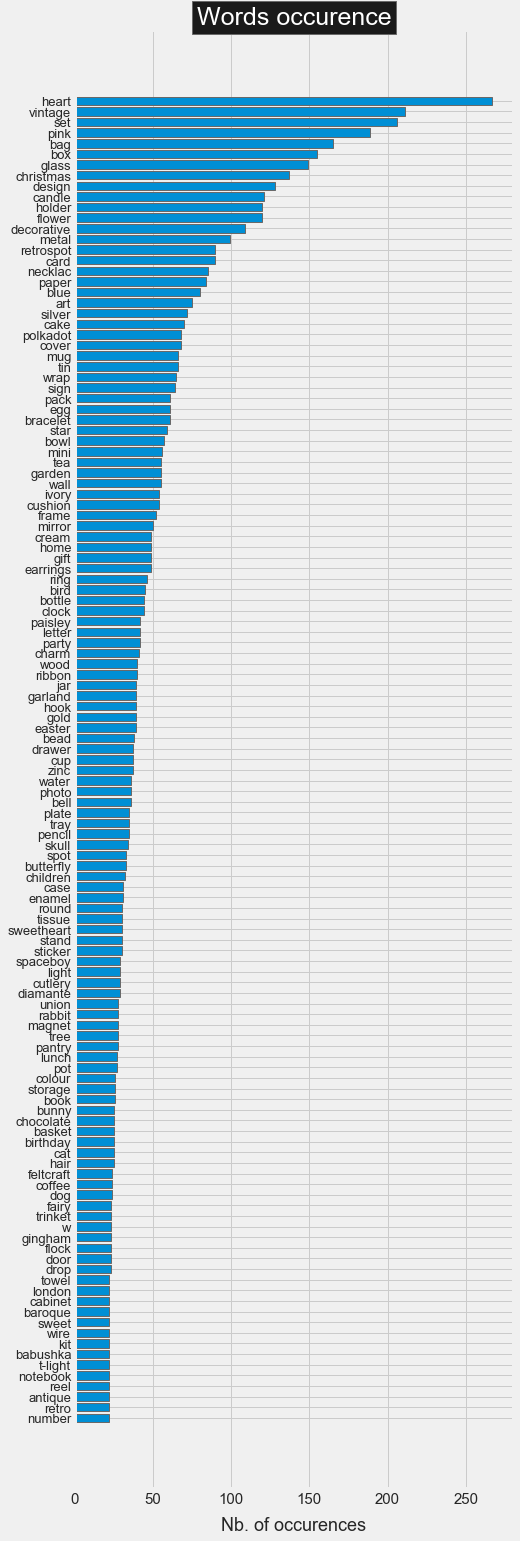

In [279]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

得到的列表包含1400多个关键词，其中最常见的出现在200多个产品中。然而，在检查列表内容时，我注意到有些名称是无用的。其他都是不携带信息的，比如颜色。因此，我将这些单词从后面的分析中删除，并且，我决定只考虑出现超过13次的单词。


In [281]:

list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 193


数据编码
现在我将使用这些关键字创建产品组。首先，定义XX矩阵
 
其中，如果产品i的描述包含单词j，则ai,j系数为1，否则为0。
XX矩阵使用one-hot编码原则表示产品描述中包含的单词。在实践中，我发现引入价格区间可以使元素数量更加均衡。因此，我在这个矩阵中增加6列，表示产品的价格范围:

为了选择合适的范围，我检查了不同组的产品数量:


In [1]:

liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

NameError: name 'df_cleaned' is not defined

In [283]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [284]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       965                 
1<.<2       1013                
2<.<3       674                 
3<.<5       611                 
5<.<10      476                 
.>10        157                 


3.2.2创建产品集群

在本节中，我将把产品分成不同的类。对于二进制编码的矩阵，计算距离最合适的度量是汉明度量。注意，sklearn的kmeans方法使用了可以使用的欧式距离，但在分类变量的情况下，它不是最佳选择。然而，为了使用Hamming的度量，我们需要使用kmodes包，这在当前的平台上是不可用的。因此，我使用kmeans方法，即使这不是最好的选择。
为了定义(近似地)最能代表数据的集群数量，我使用了轮廓线评分:


In [285]:
#3.2.2创建产品集群
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10062159302826501
For n_clusters = 4 The average silhouette_score is : 0.12601189170579502
For n_clusters = 5 The average silhouette_score is : 0.14667831112887175
For n_clusters = 6 The average silhouette_score is : 0.15139928047707105
For n_clusters = 7 The average silhouette_score is : 0.1485928410186814
For n_clusters = 8 The average silhouette_score is : 0.12016392588037594
For n_clusters = 9 The average silhouette_score is : 0.15397215134928283


在实际操作中，上述得分可以认为是等价的，因为根据运行情况，所有n_clusters >> 3的得分均为0.1±0.050.1±0.05(第一个cluster得分略低)。另一方面，我发现除了5个集群之外，有些集群只包含很少的元素。因此，我选择将数据集分为5个集群。为了保证每次运行笔记时都能很好地分类，我反复迭代，直到得到可能的最佳评分，在本例中，评分在0.15左右:

In [286]:
n_clusters = 6
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 0.1562381426042886


表征聚类的内容
----------------------

我检查每个类的元素数量:


In [145]:
#表征聚类的内容
pd.Series(clusters).value_counts()

3    920
2    894
0    708
5    629
1    442
4    303
dtype: int64

In [287]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

a /簇内评分

为了了解分类的质量，我们可以表示不同集群中每个元素的轮廓分数。这是来自sklearn文档的下一个图的目的:


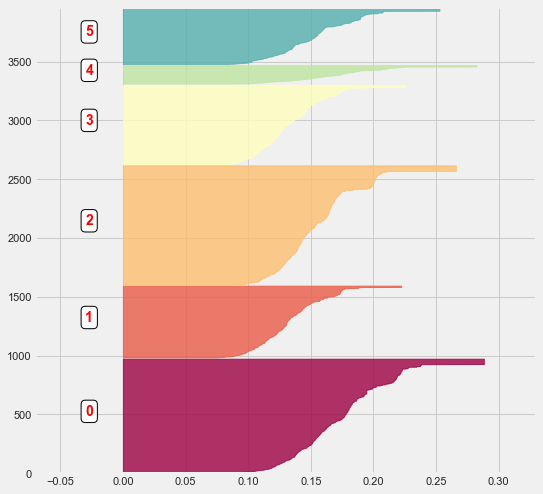

In [288]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [289]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

b /词云

现在，我们可以查看每个集群表示的对象类型。为了获得它们内容的全局视图，我确定了其中哪些关键词是最频繁的


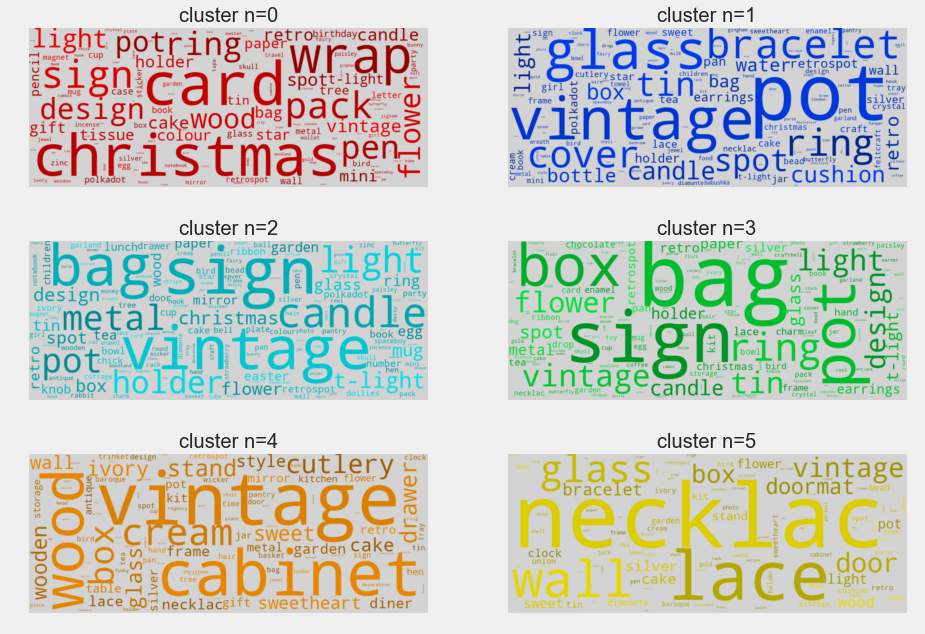

In [290]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n={}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]

for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

c主成分分析

为了确保这些集群是真正不同的，我查看了它们的组成。给定初始矩阵的大量变量，我首先执行PCA

然后检查每个分量解释的方差大小:


In [291]:
#c / Principal Component Analysis
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

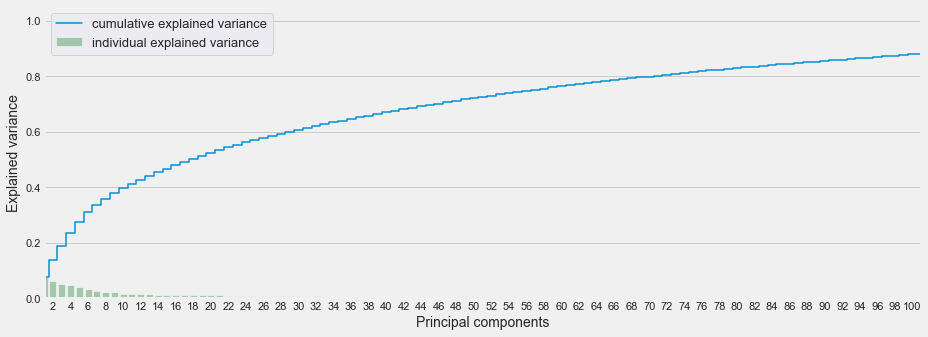

In [292]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

我们发现，解释数据所需的组件数量非常重要:我们需要100多个组件来解释数据90%的方差。在实践中，我决定只保留有限数量的组件，因为这个分解只是为了可视化数据:

In [293]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

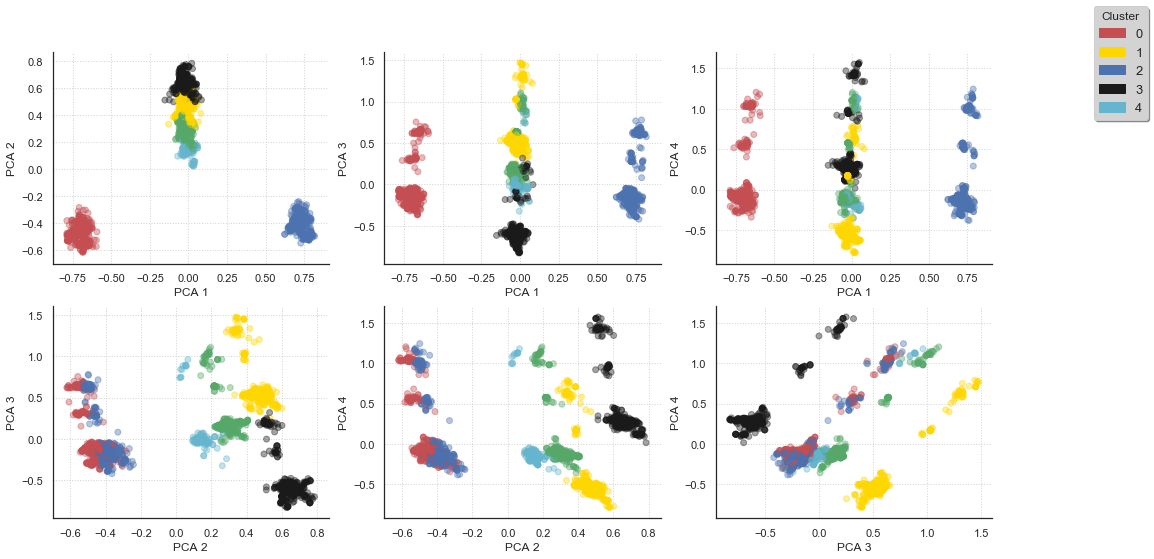

In [295]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

5 产品-地区投放
=====================
为了更进一步了解各个地区的市场特点，采用对应分析方法进行分析
之后采用LSTM神经网络进行销量预测

5.1对应分析（这部分在R语言上操作完成）
===============

In [3]:
#生成数据
df1=df_initial.groupby(['StockCode','Country']).agg({ 'tollPrice':'sum'}).copy()
df2=df1.unstack().fillna(0,inplace=True)
df2.to_csv('F:\\Ecommerce\\data\\Online_Retail.csv')
df2.head()

NameError: name 'df_initial' is not defined

5.2 销量预测
================
#销量预测
#单产品销量预测模型
#数据格式以天为单位[成交平局价格 成交最高价 最低价  价格方差  交易量 交易量方差]
#提取一天的数据


#df_pridict是进行销量预测的原始数据


In [ ]:
#数据生成
#以天为单位，使用平均价格、最低价格、最高价格、销量、平均消费间隔时间、最小消费间隔时间对预测下一个月的销量

corresp = dict()
for key, val in zip (df_productclass.index, y.T):
    corresp[key] = val

df_pridict=df_cleaned.copy()
df_pridict['categ_product'] = df_pridict.loc[:, 'StockCode'].map(corresp)
df_pridict.head(10)
df_pridict.groupby('')

In [ ]:
#销量预测
#单产品销量预测模型
#数据格式以天为单位[成交平局价格 成交最高价 最低价  价格方差  交易量 交易量方差]
#提取一天的数据






#采用预测方法：
#单个方法







#集成方法











#一类产品预测模型[成交平均价格 成交最高价 最低价  价格方差  交易量 交易量方差]


In [296]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels as sm
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
 
if __name__ == '__main__':
    mpl.rcParams['font.sans-serif'] = 'SimHei'
    mpl.rcParams['axes.unicode_minus'] = False
    data=pd.read_csv('AirPassengers.csv',header=0,names=['date','peo_num'])
    data = pd.Series(data["peo_num"].values, \
                           index=pd.DatetimeIndex(data["date"].values, freq='MS'))
    decomposition=seasonal_decompose(data,model='additive')
    trend=decomposition.trend
    seasonal=decomposition.seasonal
    residual=decomposition.resid
    #对三部分分别进行拟合
    trend.dropna(inplace=True)
    trend_diff=trend.diff(periods=2)
    trend_diff.dropna(inplace=True)
    #分别对三部分进行拟合z
    #order_trend=sm.tsa.stattools.arma_order_select_ic(trend_diff)['bic_min_order']
    order_trend=(3,2)
    model_trend=ARMA(trend_diff,order_trend)
    result_trend=model_trend.fit()
    predict_trend=result_trend.predict()+trend.shift(2)
    forecast_trend,_,_=result_trend.forecast(11)
    forecast_trend=pd.Series(forecast_trend,\
                             index=pd.DatetimeIndex(start='1960-07-01',end='1961-05-01',freq='MS'))
    trend_predict=pd.concat([predict_trend,forecast_trend],axis=0)
    for i in range(11,0,-1):
        trend_predict.values[-i]+=trend_predict[-i-2]
    value_seasonal=[]
    for i in range(5):
        value_seasonal.append(seasonal.values[i])
    forecast_seasonal=pd.Series(value_seasonal,\
                                index=pd.DatetimeIndex(start='1961-01-01',end='1961-05-01',freq='MS'))
    seasonal_predict=pd.concat([seasonal,forecast_seasonal],axis=0)
 
    residual.dropna(inplace=True)
    order_residual=sm.tsa.stattools.arma_order_select_ic(residual)['bic_min_order']
    model_residual=ARMA(residual,order_residual)
    result_residual=model_residual.fit()
    predict_residual=result_residual.predict()
    forecast_residual,_,_=result_residual.forecast(11)
    forecast_residual=pd.Series(forecast_residual,\
                                index=pd.DatetimeIndex(start='1960-07-01',end='1961-05-01',freq='MS'))
    residual_predict=pd.concat([predict_residual,forecast_residual],axis=0)
    test_data=trend_predict+seasonal_predict+residual_predict
    print(test_data)
    data.plot(label='train_data',legend=True)
    test_data.plot(label='forecast_data',legend=True)
    plt.show()

ModuleNotFoundError: No module named 'statsmodels'

六、客户类别
==================
6.1数据准备
-----------------
在上一节中，将不同的产品分为五个集群。为了准备剩下的分析，第一步是将此信息引入数据daframe。为此，我创建了categorical变量categories _product，其中表示每个产品的集群—类别。

6.1.1分组产品

在第二步中，我决定创建categories _n变量(N∈[0:5])，其中包含每个产品类别中花费的金额:


In [297]:
corresp = dict()
for key, val in zip (df_productclass.index, y.T):
    corresp[key] = val
    
df_cleaned['categ_product'] = df_cleaned.loc[:, 'StockCode'].map(corresp)
df_cleaned.head(10)#这一步将产品依据分类结果生成所属分类列

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Successful,UnitPrice1,UnitPrice2,UnitPrice3,UnitPrice4,tollPrice,QuantityCanceled,TotalPrice,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,2.55,2.55,2.55,2.55,15.30,0,15.30,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,3.39,3.39,3.39,3.39,20.34,0,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,2.75,2.75,2.75,2.75,22.00,0,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,3.39,3.39,3.39,3.39,20.34,0,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,3.39,3.39,3.39,3.39,20.34,0,20.34,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,1,7.65,7.65,7.65,7.65,15.30,0,15.30,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,1,4.25,4.25,4.25,4.25,25.50,0,25.50,0
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,1,1.85,1.85,1.85,1.85,11.10,0,11.10,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,1,1.85,1.85,1.85,1.85,11.10,0,11.10,0
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,1,1.69,1.69,1.69,1.69,54.08,0,54.08,3


In [299]:
#4.1.1 Grouping products
for i in range(6):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4','categ_5']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,3,0.00,0.0,0.0,15.3,0.0,0.0
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.0,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.0,0.0,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.0,0.0,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34,0.0,0.0,0.0,0.0,0.0


到目前为止，与单个订单相关的信息被拆分到dataframe数据的几行中(每个产品一行)。我决定收集与特定订单相关的信息，并将其放入单个条目中。因此，我创建了一个新的dataframe数据，它包含每个订单的购物篮数量，以及它在5个产品类别上的分布方式:

In [210]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Successful,QuantityCanceled,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1,0,4,0.00,0.0,0.0,0.0,15.30,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0,0,20.34,0.0,0.0,0.0,0.00,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1,0,0,22.00,0.0,0.0,0.0,0.00,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0,0,20.34,0.0,0.0,0.0,0.00,0.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1,0,0,20.34,0.0,0.0,0.0,0.00,0.0,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,1,0,0,15.30,0.0,0.0,0.0,0.00,0.0,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,1,0,0,25.50,0.0,0.0,0.0,0.00,0.0,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,1,0,0,11.10,0.0,0.0,0.0,0.00,0.0,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,1,0,0,11.10,0.0,0.0,0.0,0.00,0.0,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,1,0,4,0.00,0.0,0.0,0.0,54.08,0.0,54.08


In [300]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})


#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(6):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,InvoiceDate
2,12347.0,537626,711.79,653.59,0.0,0.0,58.20,0.0,0.0,2010-12-07 14:57:00.000001024
3,12347.0,542237,475.39,354.24,0.0,0.0,121.15,0.0,0.0,2011-01-26 14:29:59.999999744
4,12347.0,549222,636.25,259.30,0.0,0.0,376.95,0.0,0.0,2011-04-07 10:42:59.999999232
5,12347.0,556201,382.52,307.66,0.0,0.0,54.96,0.0,19.9,2011-06-09 13:01:00.000000256
6,12347.0,562032,584.91,340.76,0.0,0.0,146.35,0.0,97.8,2011-08-02 08:48:00.000000000


6.1.2 数据随时间的分离

dataframe数据 basket_price包含为期12个月的信息。稍后，我们的目标之一将是开发一个模型，该模型能够描述和预测客户从第一次访问站点时的习惯。为了能够真实的对模型进行测试，我将数据集进行了分割，保留了开发模型的前10个月和测试模型的后两个月:


In [301]:
#4.1.2 Separation of data over time
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [302]:
basket_price['InvoiceDate']<pd.to_datetime('2011/10/1')



2         True
3         True
4         True
5         True
6         True
7        False
8        False
9         True
10        True
11        True
12        True
13       False
14        True
15        True
16        True
17        True
19        True
20        True
21        True
22       False
26        True
27        True
28        True
29        True
30        True
31       False
32       False
33        True
34       False
35        True
         ...  
22153    False
22155     True
22156     True
22157    False
22160    False
22163    False
22165     True
22166     True
22167     True
22168     True
22169    False
22171     True
22172     True
22173     True
22174     True
22175     True
22176     True
22177     True
22178     True
22179     True
22180     True
22181    False
22182    False
22183    False
22184    False
22185    False
22186    False
22187     True
22188    False
22189    False
Name: InvoiceDate, Length: 18398, dtype: bool

In [303]:
set_entrainement = basket_price[basket_price['InvoiceDate']<pd.to_datetime('2011/10/1')]
set_test         = basket_price[basket_price['InvoiceDate']>=pd.to_datetime('2011/10/1')]
basket_price = set_entrainement.copy(deep = True)

6.1.3 消费者订单组合

在第二步中，我将对应于同一用户的不同条目组合在一起。因此，我确定用户购买的数量，以及所有访问期间的最低、最高、平均金额和总金额


In [304]:
#4.1.3 Consumer Order Combinations
#________________________________________________________________
# nb de visites et stats sur le montant du panier / utilisateurs
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(6):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5
0,12347.0,5,382.52,711.79,558.172000,2790.86,68.636549,0.000000,0.0,27.146113,0.0,4.217338
1,12348.0,4,227.44,892.80,449.310000,1797.24,21.003316,0.000000,0.0,58.965970,0.0,20.030714
2,12350.0,1,334.40,334.40,334.400000,334.40,77.631579,0.000000,0.0,10.406699,0.0,11.961722
3,12352.0,6,144.35,840.30,345.663333,2073.98,34.548549,40.516302,0.0,9.474537,0.0,15.460612
4,12353.0,1,89.00,89.00,89.000000,89.00,32.921348,0.000000,0.0,0.000000,0.0,67.078652


最后，我定义了两个额外的变量，分别给出了自第一次购买以来的天数(first purchase)和自上次购买以来的天数(LastPurchase):

In [305]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,68.636549,0.000000,0.0,27.146113,0.0,4.217338,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,21.003316,0.000000,0.0,58.965970,0.0,20.030714,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,77.631579,0.000000,0.0,10.406699,0.0,11.961722,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,34.548549,40.516302,0.0,9.474537,0.0,15.460612,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,32.921348,0.000000,0.0,0.000000,0.0,67.078652,134,134


特别感兴趣的客户类别是只进行一次购买的客户。例如，目标之一可能是针对这些客户以留住他们。在某种程度上，我发现这类客户占了所列客户的1/3:

In [306]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. de clients avec achat unique: 1445/3608  (40.05%)


6.2 客户类别的创建
----------
数据编码准备

dataframe数据 transactions_per_user包含生成的所有命令的摘要。这个dataframe数据中的每个条目都对应于一个特定的客户机。我使用这些信息来描述不同类型的客户，并且只保留变量的子集:

在实践中，我选择的不同变量的变化范围非常不同，在继续分析之前，我创建了一个矩阵，其中这些数据是标准化的:


In [307]:
#4.2 Creation of customers categories
#4.2.1 Data encoding
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4','categ_5']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

In [308]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [3.62305987e+00 2.59931896e+02 5.56266880e+02 3.77060362e+02
 6.15104819e+01 1.59097559e-01 6.24761710e-01 2.67014086e+01
 5.05276399e-03 1.10080470e+01]


在下面，我将创建客户集群。实际上，在创建这些集群之前，定义一个更小的维度来描述scaled_matrix矩阵是很有趣的。在本例中，我将使用这个基础来创建不同集群的表示，从而验证不同组的分离质量。因此，我事先执行PCA:

I表示每个组件解释的方差量:

我表示每个分量解释的方差量:


In [309]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

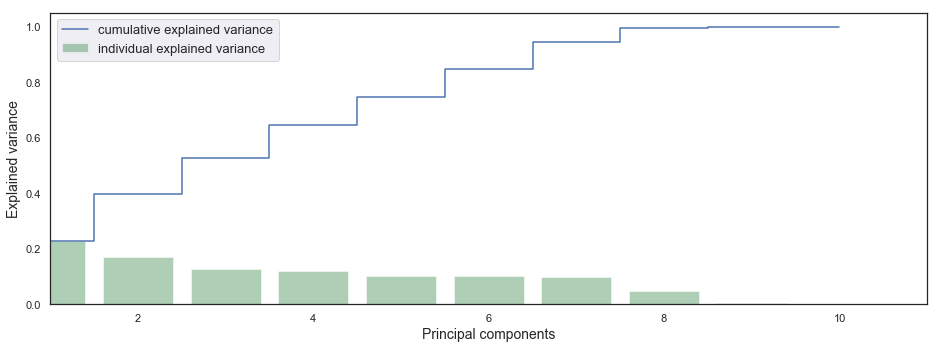

In [310]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

6.3 客户类别的创建

此时，我从前面定义的标准化矩阵中定义了客户机集群，并使用了来自scikit-learn的k-means算法。我根据剪影评分来选择簇的个数，我发现最好的是11个簇:


In [311]:
for i in range(3,15):
    n_clusters = i
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('score de silhouette: {:<.3f}'.format(silhouette_avg+0.5))


score de silhouette: 0.292
score de silhouette: 0.291
score de silhouette: 0.295
score de silhouette: 0.303
score de silhouette: 0.320
score de silhouette: 0.332
score de silhouette: 0.329
score de silhouette: 0.236
score de silhouette: 0.247
score de silhouette: 0.256
score de silhouette: 0.263
score de silhouette: 0.268


In [312]:
#4.2.2 Creation of customer categories

n_clusters = 8
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))


score de silhouette: 0.332


In [313]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,5,7,1,0,4,3,6,2
nb. de clients,2243,827,361,126,33,11,6,1


a通过主成分分析提出报告

不同群体的规模存在着一定的差异。因此，我现在将尝试理解这些集群的内容，以便验证(或不验证)这种特殊的分离。首先，我使用PCA的结果:

以便创建不同集群的表示:


In [314]:
# a / Report via the PCA
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

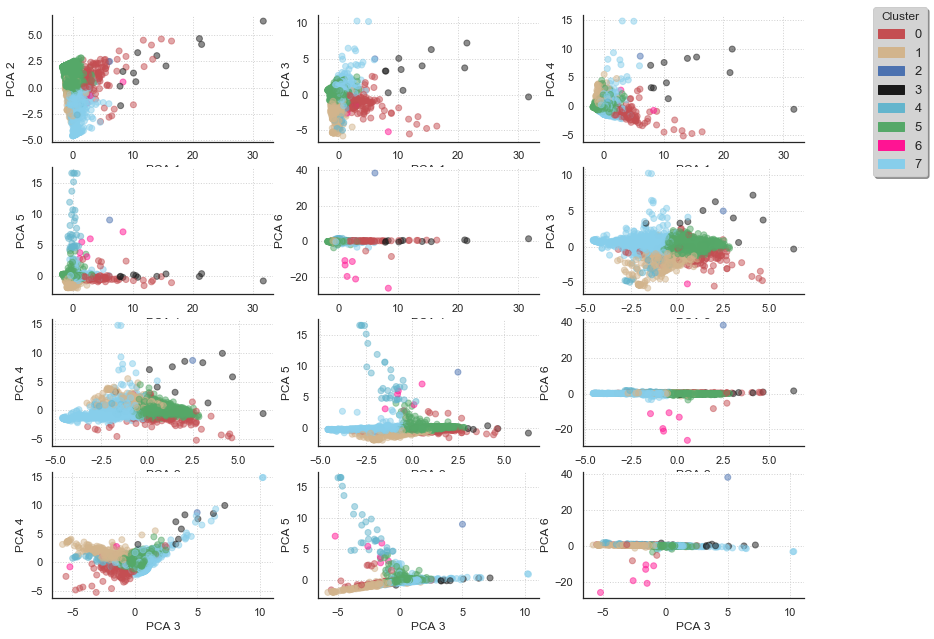

In [315]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

例如，从这个表示形式可以看出，第一个主组件允许将最小的集群与其他集群分开。更一般地说，我们看到总是存在这样一种表示，其中两个集群看起来是不同的。

b/簇内剪影评分

与产品类别一样，另一种观察分离质量的方法是观察不同集群中的silouhette得分


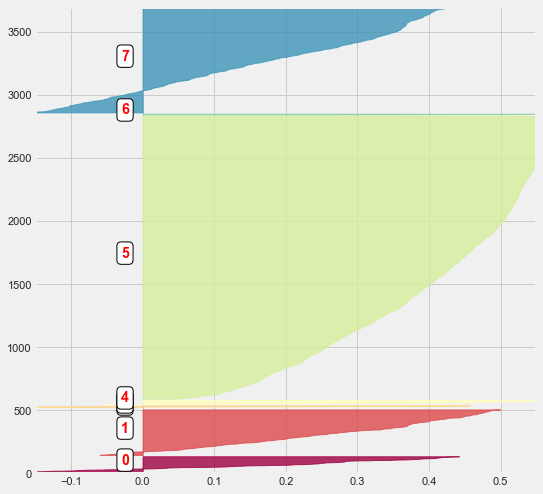

In [316]:
# b/ Score de silhouette intra-cluster
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

c /客户形态类型

在这个阶段，我已经验证了不同的集群确实是不相交的(至少在全球范围内)。它仍然需要了解每个集群中客户的习惯。为此，我首先在selected_customers dataframe数据中添加一个变量，该变量定义每个客户机所属的集群:


In [317]:
# c/ Customers morphotype
selected_customers.loc[:, 'cluster'] = clusters_clients

然后，我通过首先选择不同的客户端组来平均这个数据daframe的内容。这使我们可以访问，例如，平均篮子价格、访问次数或不同集群的客户所花费的总金额。我还确定了每组的客户数量(可变大小):

In [352]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


最后，我对dataframe数据的内容进行了重新组织，通过对不同的集群进行排序:首先，根据每个产品类别中发送的wpsend的数量，然后根据总消费金额

In [353]:
merged_df.head()

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,LastPurchase,FirstPurchase,size
cluster,,,,,,,,,,,,,,
4.0,2.181818,260.163636,385.152424,316.526582,614.738788,28.704879,0.000000,51.167111,11.136646,0.0,8.991364,116.545455,177.333333,33
1.0,2.484765,210.305845,355.562410,271.928281,708.690609,42.603381,0.034350,0.087548,13.906731,0.0,43.385015,119.803324,186.204986,361
5.0,3.068658,221.146880,432.789671,313.987880,1011.903523,73.278546,0.041082,0.152584,18.699348,0.0,7.839825,92.533660,188.734730,2243
6.0,4.500000,475.748333,1207.481667,653.421528,1916.625000,21.966790,64.392660,0.000000,9.914123,0.0,3.726427,88.166667,178.333333,6
7.0,5.672310,205.451366,555.405260,341.713364,2383.154522,39.941554,0.033545,0.156360,54.362079,0.0,5.506681,78.386941,201.111245,827


In [357]:
liste_index = []
for i in range(6):
    column = 'categ_{}'.format(i)    
    print(merged_df[merged_df[column] > 1])

             count          min           max         mean           sum  \
cluster                                                                    
4.0       2.181818   260.163636    385.152424   316.526582    614.738788   
1.0       2.484765   210.305845    355.562410   271.928281    708.690609   
5.0       3.068658   221.146880    432.789671   313.987880   1011.903523   
6.0       4.500000   475.748333   1207.481667   653.421528   1916.625000   
7.0       5.672310   205.451366    555.405260   341.713364   2383.154522   
0.0       1.936508  1430.699444   1921.001675  1657.649947   3619.740325   
2.0       6.000000    21.840000   4936.650000  1547.783333   9286.700000   
3.0      22.909091   385.752727  16513.428182  4601.666146  83676.573636   

           categ_0    categ_1    categ_2    categ_3    categ_4    categ_5  \
cluster                                                                     
4.0      28.704879   0.000000  51.167111  11.136646   0.000000   8.991364   
1.0     

In [360]:
liste_index = []
for i in range(6):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] >10].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________ 
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,size
0,4.0,2.181818,260.163636,385.152424,316.526582,614.738788,28.704879,0.000000,51.167111,11.136646,0.000000,8.991364,33
1,6.0,4.500000,475.748333,1207.481667,653.421528,1916.625000,21.966790,64.392660,0.000000,9.914123,0.000000,3.726427,6
2,4.0,2.181818,260.163636,385.152424,316.526582,614.738788,28.704879,0.000000,51.167111,11.136646,0.000000,8.991364,33
3,4.0,2.181818,260.163636,385.152424,316.526582,614.738788,28.704879,0.000000,51.167111,11.136646,0.000000,8.991364,33
4,2.0,6.000000,21.840000,4936.650000,1547.783333,9286.700000,60.261772,0.000000,0.000000,16.296316,18.230372,5.211539,1
5,1.0,2.484765,210.305845,355.562410,271.928281,708.690609,42.603381,0.034350,0.087548,13.906731,0.000000,43.385015,361
6,4.0,2.181818,260.163636,385.152424,316.526582,614.738788,28.704879,0.000000,51.167111,11.136646,0.000000,8.991364,33
7,4.0,2.181818,260.163636,385.152424,316.526582,614.738788,28.704879,0.000000,51.167111,11.136646,0.000000,8.991364,33
8,4.0,2.181818,260.163636,385.152424,316.526582,614.738788,28.704879,0.000000,51.167111,11.136646,0.000000,8.991364,33
9,5.0,3.068658,221.146880,432.789671,313.987880,1011.903523,73.278546,0.041082,0.152584,18.699348,0.000000,7.839825,2243


d /客户形态

最后，我创建了不同形态类型的表示。为了做到这一点，我定义了一个类来创建“雷达图”(从这个内核改编而来):
这允许拥有每个集群内容的全局视图:


In [361]:
# d / Customers morphology
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)
        

In [366]:
 data = np.array(merged_df.loc[index[ind], attributes])   
print(data)

[  2.18181818 316.52658249 614.73878788  28.70487904   0.
  51.16711086  11.13664582   0.           8.99136428]


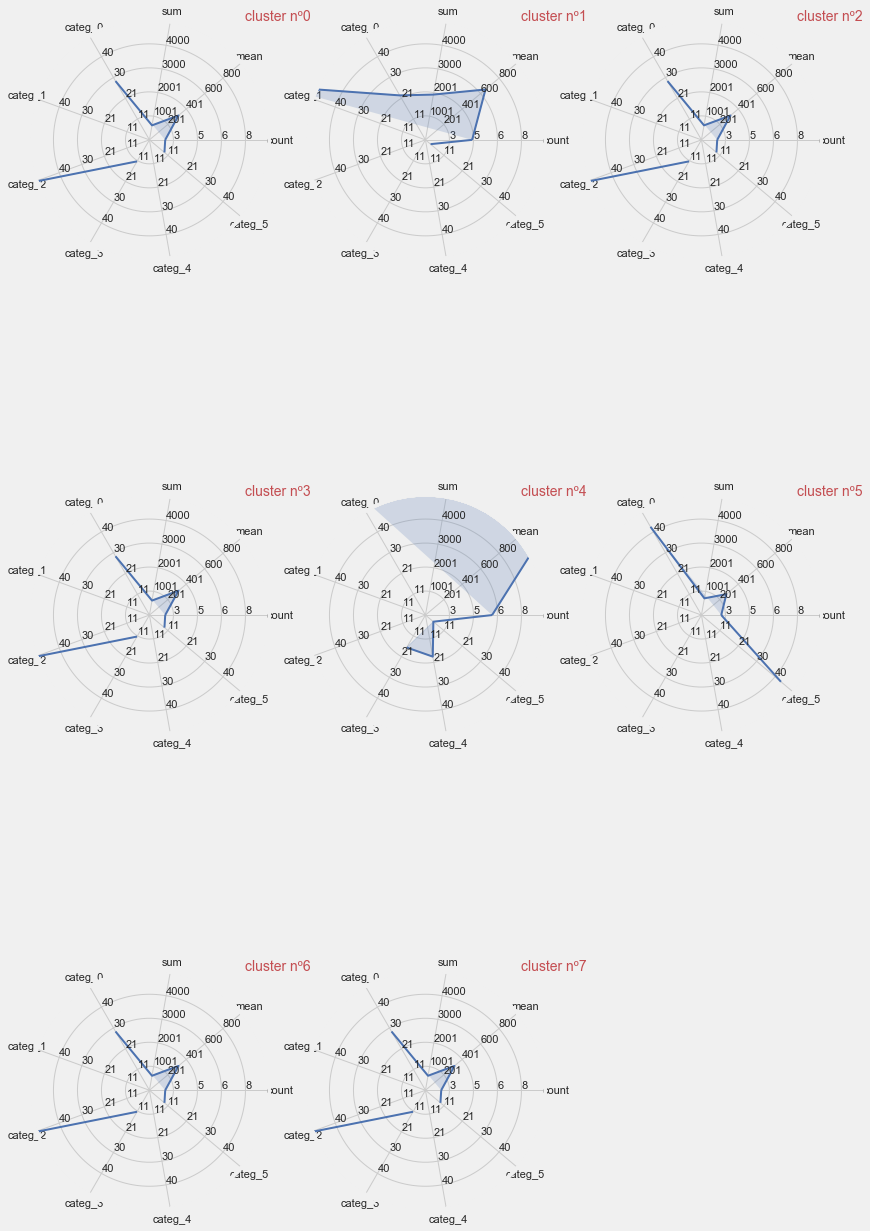

In [364]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5']
ranges = [[1, 10], [1, 1000], [1, 5000], [1, 50], [1, 50], [1, 50], [1, 50], [1, 50],[1, 50]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(8):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

可以看出，不同集群对应于某一特定产品类别的采购不同、篮子平均(平均值)、客户总消费(总额)或总访问次数(计数)。

七、 客户的分类
==========
在本部分中，我们的目标是调整一个分类器，该分类器将在上一节中建立的不同客户机类别中对消费者进行分类。目的是使这种分类在第一次访问时成为可能。为了实现这个目标，我将测试几个在scikit-learn中实现的分类器。首先，为了简化它们的使用，我定义了一个类，它允许接口这些不同分类器共有的几个功能:


In [98]:
# 5. Classification of customers
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

目标是定义类客户所属,一旦它的第一次访问,我只保留变量描述篮子里的内容,并且不考虑相关的变量访问的频率或篮子价格随时间的变化:

In [99]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']最后，我将数据集分为训练集和测试集:

最后，我将数据集分为训练集和测试集:

In [100]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

7.1支持向量机分类器(SVC)
----------------------
我使用的第一个分类器是SVC分类器。为了使用它，我创建了Class_Fit类的一个实例，然后调用grid_search()。调用此方法时，我提供如下参数:


In [102]:
# 5.1 Support Vector Machine Classifier (SVC)
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)

Precision: 75.75 % 


5.1.1混淆矩阵

结果的准确性似乎是正确的。但是，让我们记住，当定义了不同的类时，得到的类之间的大小是不平衡的。特别是，一个类包含大约40%的客户机。这是混淆矩阵的主题，为了表示它们，我使用了sklearn文档的代码


In [103]:
# 5.1.1 Confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


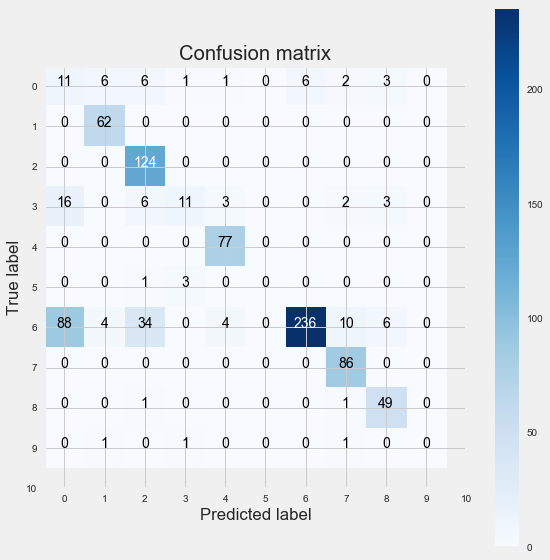

In [104]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

5.1.2学习曲线

测试契合度的一个典型方法是画一条学习曲线。特别是，这种类型的曲线允许检测模型中可能存在的缺陷，例如与过拟合或欠拟合有关。这也显示了模式在多大程度上可以从更大的数据样本中获益。为了绘制这条曲线，我再次使用了scikit-learn文档代码



In [105]:
# 5.1.2 Learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

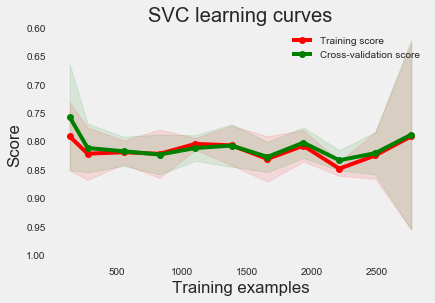

In [106]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

从曲线上可以看出，随着样本量的增加，列车与交叉验证曲线收敛到相同的极限。这是典型的低方差建模，证明了模型不存在过拟合问题。此外，我们可以看到，训练曲线的准确性是正确的，这是低偏差的同义词。因此，模型对数据的拟合不充分。

5.2逻辑回归
----------
现在考虑逻辑回归分类器。和之前一样，我创建了一个Class_Fit类的实例，在训练数据上调整模型，并查看预测与实际值的比较:


In [107]:
# 5.2 Logistic Regression
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 86.37 % 


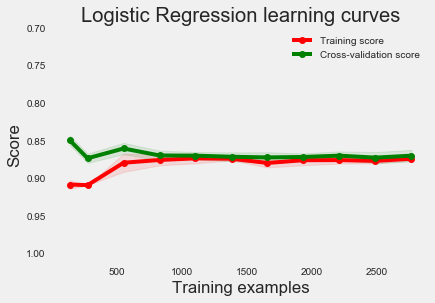

In [108]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

5.3k-Nearest Neighbors
-----------------

In [109]:
# 5.3 k-Nearest Neighbors
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 78.52 % 


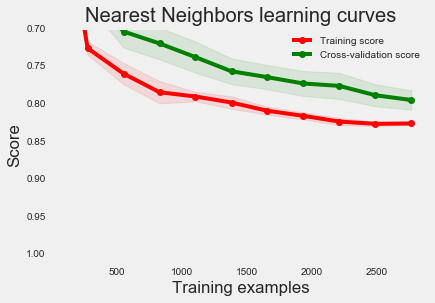

In [110]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

5.4决策树
-------

In [111]:
# 5.4 Decision Tree
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 83.14 % 


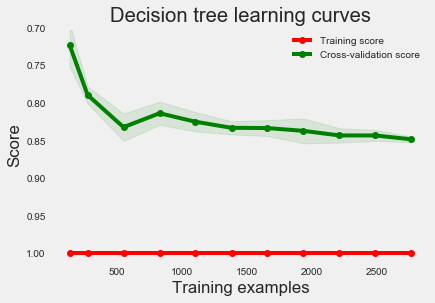

In [112]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

5.5随机森林
------

In [113]:
# 5.5 Random Forest
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 90.88 % 


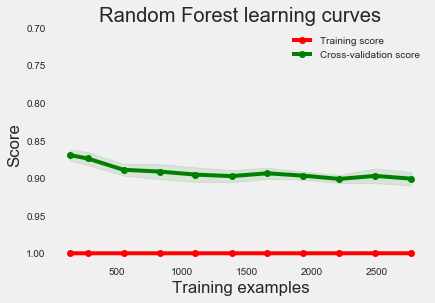

In [114]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

5.6 AdaBoost Classifier
-----

In [115]:
# 5.6 AdaBoost Classifier
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 64.67 % 


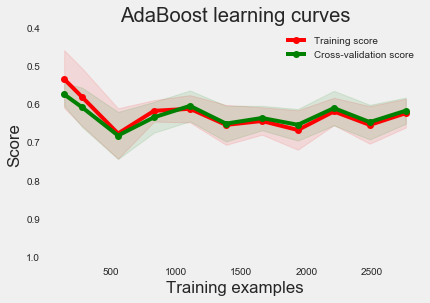

In [116]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

5.7 Gradient Boosting Classifier
------

In [117]:
# 5.7 Gradient Boosting Classifier
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 91.11 % 


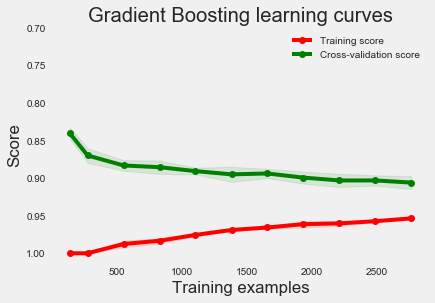

In [118]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

5.8让我们投票吧!
--------
最后，将前几节给出的不同分类器的结果结合起来，对分类模型进行改进。这可以通过选择大多数分类器所表示的客户类别来实现。为此，我使用了sklearn包中的VotingClassifier方法。作为第一步，我使用之前找到的最佳参数来调整各个分类器的参数:


In [119]:
# 5.8 Let's vote !
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

然后定义一个分类器，将各个分类器的结果进行合并:

In [120]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

In [121]:
votingC = votingC.fit(X_train, Y_train)

In [122]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.69 % 


注意，在定义votingC分类器时，我只使用了上面定义的全部分类器的子样本，只保留了随机森林、k近邻和梯度增强分类器。实际上，这一选择是根据下一节所进行的分类的成绩作出的。

八、 测试的预测
=======
在前一节中，我们对一些分类器进行了训练，以便对客户进行分类。在那之前，整个分析都是基于前10个月的数据。在本节中，我测试了存储在set_test dataframe数据中的数据集的最后两个月的模型:

在第一步,我重组这些数据按照相同的程序作为训练集上使用。然而,我纠正数据考虑两者之间的时差数据集和权重变量数和金额获得训练集的等价:


In [124]:
# 6. Testing predictions
basket_price = set_test.copy(deep = True)

In [125]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,10,224.82,1294.32,759.57,7595.70,24.271627,5.634767,20.017905,17.732401,32.343299
1,12349.0,5,1757.55,1757.55,1757.55,8787.75,10.713778,20.389178,26.506216,30.145373,12.245455
2,12352.0,5,311.73,311.73,311.73,1558.65,7.217785,17.290604,34.420813,32.335675,8.735123
3,12356.0,5,58.35,58.35,58.35,291.75,0.000000,0.000000,0.000000,100.000000,0.000000
4,12357.0,5,6207.67,6207.67,6207.67,31038.35,28.350089,25.189000,18.475531,13.300643,14.684737


In [126]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

然后，我将dataframe数据转换为一个矩阵，并只保留定义使用者所属类别的变量。在这一级，我回顾了在训练集上使用的归一化方法:

这个矩阵中的每一行都包含一个消费者的购买习惯。在这个阶段，使用这些习惯来定义消费者所属的类别是一个问题。这些类别已在第4节中确定。在这个阶段，重要的是要记住，这个步骤并不对应于分类阶段本身。在这里，我们通过定义客户所属的类别来准备测试数据。然而，这个定义使用了在2个月内获得的数据(通过变量count、min、max和sum)。第5节中定义的分类器使用一组更受限制的变量，这些变量将从第一次购买客户机时定义。

这里的问题是在两个月内使用可用数据，并使用这些数据定义客户所属的类别。然后，通过将分类器的预测与这些类别进行比较，对分类器进行测试。为了定义客户机所属的类别，我回顾了第4节中使用的kmeans方法的实例。该实例的predict方法计算消费者到11个客户端类的质心的距离，最小的距离定义属于不同类别:

最后，为了准备分类器的执行，选择分类器所作用的变量就足够了:

现在只需要检查在第5节中训练过的不同分类器的预测:


In [127]:
Y = kmeans.predict(scaled_test_matrix)
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 67.46 % 
______________________________ 
Logostic Regression
Precision: 73.77 % 
______________________________ 
k-Nearest Neighbors
Precision: 68.68 % 
______________________________ 
Decision Tree
Precision: 75.38 % 
______________________________ 
Random Forest
Precision: 78.24 % 
______________________________ 
Gradient Boosting
Precision: 78.17 % 


最后，如5.8节所述，可以通过结合各自的预测来提高分类器的质量。在这个层次上，我选择混合随机森林，梯度增强和k近邻预测，因为这将导致预测的轻微改进:

In [128]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 78.99 % 


七、结论
======
本文首先明确数据挖掘的目标——为电商平台挖掘有价值的信息，分析平台的销售情况，为平台的发展提出合理的建议。接着对电商数据进行解读，以最少损失数据为原则对缺失和异常数据处理，将数据规整，得到规范的数据。然后，从电商平台销售、商品、客户的视角，进行探索性数据分析和统计推断。
为了更加深入的分析平台的交易情况，本团队采用K-means聚类分析方法，依据交易信息将产品的分类为爆款、常年流行物品、季节性流行物品、冷门物品、低价值物品，并详细分析每一类产品的情况给出相应的管理建议。同时，构建产品定价模型，分析产品定价是否合理，并且采用时间序列预测其产品的销售趋势以及价格波动。针对平台的客户，本团队结合消费者行为理论，通过对应分析、RFM客户管理模型将客户进行细分并且提出管理策略建议。
